In [144]:
import numpy as np
import pandas as pd
import bambi as bmb
import scipy.stats as stats
from typing import Sequence
from matplotlib import pyplot as plt
from dataclasses import dataclass, field
from numpy.typing import NDArray
from cmdstanpy import CmdStanModel, CmdStanMCMC
from data335 import lm
from arviz import InferenceData

In [2]:
model = CmdStanModel(stan_file="slr.stan")
hibbs = pd.read_csv("../data/hibbs.csv")
data = {"N": len(hibbs), "x": hibbs["growth"], "y": hibbs["vote"]}

In [3]:
fit = model.sample(data)

20:15:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:15:23 - cmdstanpy - INFO - CmdStan done processing.


In [4]:
draws = fit.draws_pd()[["a", "b", "sigma"]]
draws

,a,b,sigma
0,49.7843,1.44091,5.16726
1,48.8445,2.18405,4.78302
2,45.0120,3.64389,2.92754
3,44.2022,3.92165,2.96364
4,47.2719,2.58765,3.90654
...,...,...,...
3995,48.1138,1.37997,4.88762
3996,45.5759,2.61831,3.78179
3997,46.4234,3.73949,4.31466
3998,45.7316,2.57135,3.43379


In [5]:
mtcars = pd.read_csv("../data/mtcars.csv", index_col="model")
target = "mpg"
features = [c for c in mtcars.columns if c != target]

In [6]:
y = mtcars[target].to_numpy()
x = mtcars[features].to_numpy()
N, K = x.shape
data = {"N": N, "K": K, "x": x, "y": y}

In [7]:
model = CmdStanModel(stan_file="lr.stan")

In [8]:
fit = model.sample(data)

20:15:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:15:35 - cmdstanpy - INFO - CmdStan done processing.


In [152]:
@dataclass(kw_only=True)
class StanLMFit:
    target: str
    features: Sequence[str]
    model: CmdStanModel
    stan_mcmc: CmdStanMCMC = field(repr=False)
    draws: pd.DataFrame = field(init=False, repr=False)

    median: pd.Series = field(init=False, repr=False)
    mad_sd: pd.Series = field(init=False, repr=False)
    summary: pd.DataFrame = field(init=False)

    def __post_init__(self):
        stan_mcmc = self.stan_mcmc
        features = self.features

        stan_draws = stan_mcmc.draws_pd()
        draws = pd.DataFrame(
            {
                "(Intercept)": stan_draws["alpha"],
                **{
                    feature: stan_draws[f"beta[{i + 1}]"]
                    for i, feature in enumerate(features)
                },
                "sigma": stan_draws["sigma"],
            }
        )

        median = draws.median()
        median.name = "median"
        mad_sd = pd.Series(
            stats.median_abs_deviation(draws, axis=0), median.index, name="mad_sd"
        )
        summary = pd.concat([median, mad_sd], axis=1)

        self.draws = draws
        self.median = median
        self.mad_sd = mad_sd
        self.summary = summary

    def _repr_html_(self):
        summary = self.summary
        return summary._repr_html_()  # type: ignore


def stan_lm(
    data: pd.DataFrame,
    *,
    features: Sequence[str] | None = None,
    target: str,
):
    y = data[target].to_numpy(dtype=np.float64)
    N = len(y)
    if features is None:
        features = [c for c in data.columns if c != target]
    x = data[features].to_numpy(dtype=np.float64)
    K = x.shape[1]
    if K == 0:
        raise Exception(f"Degeneate data matrix: shape = {x.shape}")
    stan_data = dict(N=N, K=K, x=x, y=y)
    model = CmdStanModel(stan_file="lr.stan")
    stan_mcmc = model.sample(data=stan_data)
    fit = StanLMFit(
        target=target,
        features=features,
        model=model,
        stan_mcmc=stan_mcmc,
    )
    return fit

In [153]:
earnings = pd.read_csv("../data/earnings.csv")
hw = earnings[["height", "weight"]].dropna()
hw["height"] = hw["height"] - hw["height"].mean()

In [154]:
stan_fit = stan_lm(hw, target="weight", features=["height"])
stan_fit

09:23:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:23:06 - cmdstanpy - INFO - CmdStan done processing.


,median,mad_sd
(Intercept),156.31600,0.46300
height,4.94585,0.12376
sigma,28.97870,0.33730


In [164]:
model = stan_fit.model
model

CmdStanModel: name=lr
	 stan_file=/Users/mgreenbe/DATA335W2025/code/lr.stan
	 exe_file=/Users/mgreenbe/DATA335W2025/code/lr
	 compiler_options=stanc_options={}, cpp_options={}

In [143]:
lm_fit = lm(hw, target="weight", features=["height"])
lm_fit

,estimate,standard error,t-statistic,p-value
estimand,,,,
coef(1),156.305198,0.68451,228.346169,0.0
coef(height),4.949380,0.178467,27.732684,0.0
sigma,28.952420,,,


In [148]:
@dataclass
class BambiLMFit:
    formula: str
    model: bmb.Model
    inference_data: InferenceData = field(repr=False)
    draws: pd.DataFrame = field(init=False, repr=False)
    summary: pd.DataFrame = field(init=False)

    def __post_init__(self):
        inference_data = self.inference_data
        posterior = inference_data["posterior"]
        draws = pd.DataFrame(
            dict({k: v.to_numpy().ravel() for k, v in posterior.data_vars.items()})
        )

        median = draws.median()
        median.name = "median"
        mad_sd = pd.Series(
            stats.median_abs_deviation(draws, axis=0), median.index, name="mad_sd"
        )
        summary = pd.concat([median, mad_sd], axis=1)

        self.draws = draws
        self.median = median
        self.mad_sd = mad_sd
        self.summary = summary

    def _repr_html_(self):
        summary = self.summary
        return summary._repr_html_()  # type: ignore


def bambi_lm(
    formula: str,
    data: pd.DataFrame,
):
    model = bmb.Model(formula, data)
    inference_data = model.fit()
    bambi_lm_fit = BambiLMFit(
        formula=formula, model=model, inference_data=inference_data
    )
    return bambi_lm_fit

In [149]:
bambi_fit = bambi_lm("weight ~ height", hw)
bambi_fit

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, height]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,median,mad_sd
sigma,28.959953,0.338997
Intercept,156.309203,0.452044
height,4.950102,0.119882


Sampling: [Intercept, height, sigma]


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'sigma'}>,
       <Axes: title={'center': 'height'}>], dtype=object)

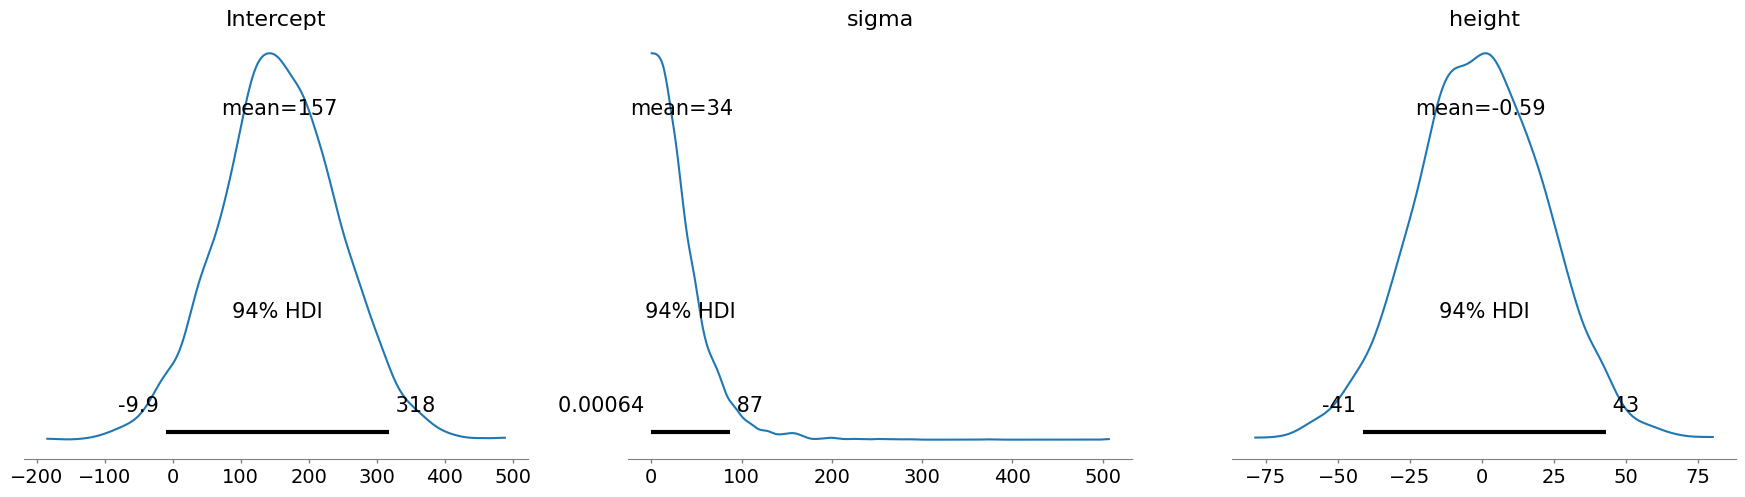

In [151]:
model = bambi_fit.model
model.plot_priors()

In [147]:
stan_fit

,median,mad_sd
(Intercept),156.2930,0.449500
height,4.9498,0.117225
sigma,28.9789,0.318800
